### Overview

Here's a simple example to illustrate how to formulate an inference problem and compare different predictors.

Let's solve the following inference problem:

* our unobservable cause XT is a 2d point inside a box
* the observable effect Y is 5 points sampled from a gaussian centered on XT + uniform noise points
* our prediction X is a 2d point

We want to predict the cause X given an observation Y.

### Steps

1. [Define inputs and outputs](#define-inputs-outputs)
2. [Implement the simulator](#simulator)
3. [Implement loss function](#loss)
4. [Implement predictors](#predictors)
5. [Run the experiment](#experiment)

In [1]:
%matplotlib inline
from typing import List, Tuple
import numpy as np
from  numpy import ndarray
import matplotlib.pyplot as plt
from petutils.experiment import Experiment, Runner, Predictor

In [2]:
# bounds of the box
X_MIN, X_MAX = 0.0, 1.0
Y_MIN, Y_MAX = 0.0, 1.0
# standard deviation of the gaussian
STD = 0.05

### Define inputs and outputs <a name="define-inputs-outputs"></a>

Our true XT and predicted X spaces coincide in this case: they're simply a 2d point.

In [3]:
class X:
    def __init__(self, x: float, y: float):
        self.x = x
        self.y = y

    def array(self):
        return np.array([self.x, self.y])
    
XT = X

Our Y space is sets of 2d points:

In [4]:
class Y:
     def __init__(self, xs: ndarray, ys: ndarray):
        self.xs = xs
        self.ys = ys

### Implement the simulator <a name="simulator"></a>

An observation is generated by sampling from a gaussian centered on the X point and adding a noise point sampled from a uniform distribution:

In [5]:
class Simulator:
    def sample(self) -> Tuple[XT, Y]:
        xt = X(np.random.uniform(X_MIN, X_MAX), np.random.uniform(Y_MIN, Y_MAX))

        noise_x = np.random.uniform(X_MIN, X_MAX)
        noise_y = np.random.uniform(Y_MIN, Y_MAX)

        xs = np.append(np.random.normal(xt.x, STD, 5), noise_x)
        ys = np.append(np.random.normal(xt.y, STD, 5), noise_y)

        y = Y(xs, ys)
        return xt, y

Let's see what a sample looks like:

(0.0, 1.0)

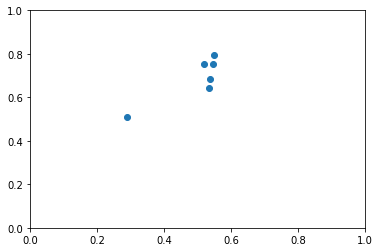

In [6]:
np.random.seed(3)
sim = Simulator()
xt, y = sim.sample()
plt.scatter(y.xs, y.ys)
plt.xlim(X_MIN, X_MAX)
plt.ylim(Y_MIN, Y_MAX)

### Implement loss function <a name="loss"></a>

Our loss function is the euclidean distance between the true and predicted points:

In [7]:
class L2Loss:
    def loss(self, xt: XT, x: X) -> float:
        return np.linalg.norm(xt.array() - x.array())

### Implement predictors <a name="predictors"></a>

We're evaluating 3 different predictors:
* DumbPredictor always predicts (0, 0)
* MeanPredictor chooses a point using the means
* RobustPredictor chooses a point using the medians, which is more robust to outliers

In [8]:
class DumbPredictor:
    def predict(self, y: Y) -> X:
        return X(0, 0)


class MeanPredictor:
    def predict(self, y: Y) -> X:
        return X(y.xs.mean(), y.ys.mean())


class RobustPredictor:
    def predict(self, y: Y) -> X:
        return X(np.median(y.xs), np.median(y.ys))

### Run the experiment <a name="experiment"></a>

We now have all we need to create an experiment to compare these approaches:

In [9]:
loss = L2Loss()
predictors: List[Predictor] = [DumbPredictor(), MeanPredictor(), RobustPredictor()]

expt = Experiment(sim, predictors, loss)

Let's run the experiment and compare predictors; the robust predictor should win:

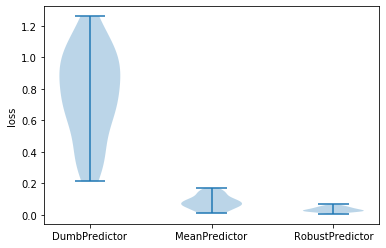

In [10]:
runner = Runner(expt)
runner.run(50)
runner.plot_summary()